In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Polynomial regression on single sliding window 
def fit_window(series, start_idx, end_idx):
    indexes = list(range(start_idx, end_idx))
    x_train = np.array(indexes).reshape(-1, 1)
    y_train = np.array(series[start_idx:end_idx]).reshape(-1, 1)
    lin_reg = LinearRegression()
    poly_features = PolynomialFeatures(degree=2, include_bias=True)
    x_poly = poly_features.fit_transform(x_train)
    lin_reg.fit(x_poly, y_train)
    coeffs = [lin_reg.coef_[0][2], lin_reg.coef_[0][1], lin_reg.intercept_[0]]
    y_pred = lin_reg.predict(x_poly)
    return x_train, y_train, y_pred, coeffs

# Polynomial regression of a whole series
def fit_series(series, start_idx, fit_length):
    x = []
    y = []
    y_pred = []
    coeffs = []
    n_data = len(series)
    if start_idx > 0:
        x_train, y_train, y_fit, coeff = fit_window(series, 0, start_idx)
        x.extend(x_train)
        y.extend(y_train)
        y_pred.extend(y_fit)
        m = -coeff[1]**2 / (4 * coeff[0]) + coeff[2]
        x_size = len(x_train)
        m_vec = [m] * x_size
        coeffs.extend(m_vec)

    while start_idx < n_data - 1:
        if start_idx + fit_length > n_data:
            end_idx = n_data
        else:
            end_idx = start_idx + fit_length
        x_train, y_train, y_fit, coeff = fit_window(series, start_idx, end_idx)
        x.extend(x_train)
        y.extend(y_train)
        y_pred.extend(y_fit)
        m = -coeff[1]**2 / (4 * coeff[0]) + coeff[2]
        x_size = len(x_train)
        m_vec = [m] * x_size
        coeffs.extend(m_vec)
        start_idx = end_idx

    return x, y, y_pred, coeffs


In [3]:
# Runtime configuration
input_path = r'inputs'
output_path = r'outputs'
input_file = os.path.join(input_path, 'observed_data.tsv')
yearly_trends_file = os.path.join(output_path, 'yearly_trends.tsv')
yearly_residuals_file = os.path.join(output_path, 'yearly_residuals.tsv')
weekly_trends_file = os.path.join(output_path, 'weekly_trends.tsv')
weekly_residuals_file = os.path.join(output_path, 'weekly_residuals.tsv')
weekly_maxima_file = os.path.join(output_path, 'weekly_maxima.tsv')
cluster_probas_file = os.path.join(output_path, 'cluster_probas.tsv')
cluster_flags_file = os.path.join(output_path, 'cluster_flags.tsv')
isolated_probas_file = os.path.join(output_path, "isolated_probas.tsv")
isolated_flags_file = os.path.join(output_path, "isolated_flags.tsv")
final_probas_file = os.path.join(output_path, "final_probas.tsv")
final_flags_file = os.path.join(output_path, "final_flags.tsv")
export_intermediate = True

In [4]:
# Quick information on input data
full_df = pd.read_csv(input_file, sep='\t')
variables = list(full_df)[1:]
dimension = len(variables)
n_data = full_df.shape[0]
print('Variables: {}'.format(variables))
print('Number of entries: {:,}'.format(n_data))

Variables: ['y1', 'y2', 'y3', 'y4', 'y5', 'y6', 'y7', 'y8', 'y9', 'y10']
Number of entries: 729,145


In [5]:
# Fit yearly trends to full series using 2nd order polynomials
# Remove trend to calculate yearly residuals
# Fit weekly trends to yearly residuals using 2nd order polynomials
# Remove weekly trends to calculate weekly residuals
# Calculate maximas of weekly trends

# Yearly trends
yearly_trends = {'datetime': full_df['datetime']}
yearly_residuals = {'datetime': full_df['datetime']}
monthly_offset = 65 * 24
for v in variables:
    print('Fitting yearly trends for series {}'.format(v))
    x, y, y_pred, coeffs = fit_series(full_df[v],
                                      start_idx=monthly_offset, fit_length=365*24)
    yearly_trends[v] = [item[0] for item in y_pred]
    yearly_residuals[v] = [y[i][0] - y_pred[i][0] for i in range(len(y))]

yearly_trends_df = pd.DataFrame(yearly_trends)
yearly_residuals_df = pd.DataFrame(yearly_residuals)

# Weekly trends
weekly_trends = {'datetime': full_df['datetime']}
weekly_residuals = {'datetime': full_df['datetime']}
weekly_maxima = {'datetime': full_df['datetime']}
print()
weekly_offset = 2 * 24
for v in variables:
    print('Fitting weekly trends for series {}'.format(v))
    x, y, y_pred, coeffs = fit_series(yearly_residuals[v],
                                      start_idx=weekly_offset, fit_length=7*24)
    weekly_trends[v] = [item[0] for item in y_pred]
    weekly_residuals[v] = [y[i][0] - y_pred[i][0] for i in range(len(y))]
    weekly_maxima[v] = coeffs

weekly_trends_df = pd.DataFrame(weekly_trends)
weekly_residuals_df = pd.DataFrame(weekly_residuals)
weekly_maxima_df = pd.DataFrame(weekly_maxima)

# #### Exporting ####
if export_intermediate:
    print()
    print('Exporting yearly trends to tsv...')
    yearly_trends_df.to_csv(yearly_trends_file, sep="\t", index=False)
    print('Exporting yearly residuals to tsv...')
    yearly_residuals_df.to_csv(yearly_residuals_file, sep="\t", index=False)
    print('Exporting weekly trends to tsv...')
    weekly_trends_df.to_csv(weekly_trends_file, sep="\t", index=False)
    print('Exporting weekly residuals to tsv...')
    weekly_residuals_df.to_csv(weekly_residuals_file, sep="\t", index=False)
    print('Exporting weekly maxima to tsv...')
    weekly_maxima_df.to_csv(weekly_maxima_file, sep="\t", index=False)

print("Done!")

Fitting yearly trends for series y1
Fitting yearly trends for series y2
Fitting yearly trends for series y3
Fitting yearly trends for series y4
Fitting yearly trends for series y5
Fitting yearly trends for series y6
Fitting yearly trends for series y7
Fitting yearly trends for series y8
Fitting yearly trends for series y9
Fitting yearly trends for series y10

Fitting weekly trends for series y1
Fitting weekly trends for series y2
Fitting weekly trends for series y3
Fitting weekly trends for series y4
Fitting weekly trends for series y5
Fitting weekly trends for series y6
Fitting weekly trends for series y7
Fitting weekly trends for series y8
Fitting weekly trends for series y9
Fitting weekly trends for series y10

Exporting yearly trends to tsv...
Exporting yearly residuals to tsv...
Exporting weekly trends to tsv...
Exporting weekly residuals to tsv...
Exporting weekly maxima to tsv...
Done!


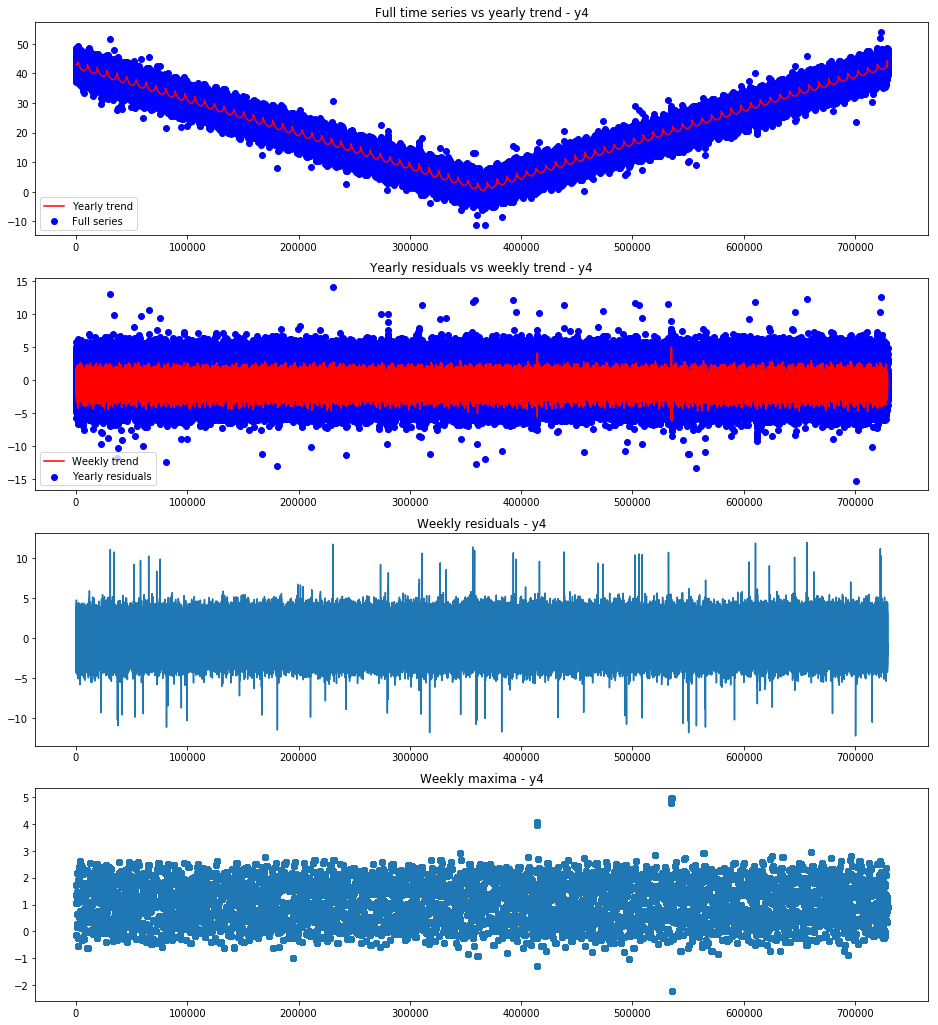

In [6]:
# #### Visualizing trends and residuals ####
yearly_trends_df = pd.read_csv(yearly_trends_file, sep="\t")
yearly_residuals_df = pd.read_csv(yearly_residuals_file, sep="\t")
weekly_trends_df = pd.read_csv(weekly_trends_file, sep="\t")
weekly_residuals_df = pd.read_csv(weekly_residuals_file, sep="\t")
weekly_maxima_df = pd.read_csv(weekly_maxima_file, sep="\t")
v = 'y4'
full_series = np.array(full_df[v]).reshape(-1, 1)
yearly_trends_series = np.array(yearly_trends_df[v]).reshape(-1, 1)
yearly_residuals_series = np.array(yearly_residuals_df[v]).reshape(-1, 1)
weekly_trends_series = np.array(weekly_trends_df[v]).reshape(-1, 1)
weekly_residuals_series = np.array(weekly_residuals_df[v]).reshape(-1, 1)
weekly_maxima_series = np.array(weekly_maxima_df[v]).reshape(-1, 1)
start = 0
end = n_data
# start = 572000
# end = 580000
plot_idx = range(start, end)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(16, 18))
grid = plt.GridSpec(4, 1, wspace=0.1, hspace=0.2)
# Full time series vs yearly trend
ax1 = plt.subplot(grid[0, 0])
ax1.title.set_text('Full time series vs yearly trend - ' + v)
ax1.scatter(plot_idx, full_series[start:end], color='blue', label='Full series')
ax1.plot(plot_idx, yearly_trends_series[start:end], color='red', label='Yearly trend')
ax1.legend(loc='best')
# Yearly residuals vs weekly trend
ax2 = plt.subplot(grid[1, 0])
ax2.title.set_text('Yearly residuals vs weekly trend - ' + v)
ax2.scatter(plot_idx, yearly_residuals_series[start:end], color='blue', label='Yearly residuals')
ax2.plot(plot_idx, weekly_trends_series[start:end], color='red', label='Weekly trend')
ax2.legend(loc='best')
# Weekly residuals
ax3 = plt.subplot(grid[2, 0])
ax3.title.set_text('Weekly residuals - ' + v)
ax3.plot(plot_idx, weekly_residuals_series[start:end])
# Weekly maxima
ax4 = plt.subplot(grid[3, 0])
ax4.title.set_text('Weekly maxima - ' + v)
ax4.scatter(plot_idx, weekly_maxima_series[start:end])

plt.show()

In [194]:
# Simple detection method using the Normal distribution.
# Input the number of standard deviations beyond which an event x is deemed
# an anomaly. We then postulate the probability shape (decision function)
# prob = 1 - exp(-[z / tau]^2)
# where z is the standardized event z = (x - mean) / stdev and tau
# is a parameter numerically set so that the probability is 90% at
# the chosen number of standard deviations.
# 5 standard deviations is default as it corresponds to the confidence level
# for declaring a "discovery" in particle physics.

class PercentileDetection:
    def __init__(self, anomaly_std=5.0):
        self.mean = None
        self.std_dev = None
        # Calibration of decision function/anomaly probability
        self.anomaly_std = anomaly_std
        self.anomaly_conf = 0.90  # Anomaly std threshold is mapped to 0.90%
        self.tau = self.anomaly_std / np.sqrt(-np.log(1.0 - self.anomaly_conf))

    def fit(self, x_):
        self.mean = pd.Series(x_[:, 0]).mean()
        self.std_dev = pd.Series(x_[:, 0]).std()

    def predict(self, x_):
        are_outside = []
        decisions = self.decision_function(x_)
        for i in range(len(x_)):
            are_outside.append(decisions[i] > self.anomaly_conf)
        return are_outside, decisions

    def fit_predict(self, x_):
        self.fit(x_)
        return self.predict(x_)

    def decision_function(self, x_):
        size = len(x_)
        prob = np.ndarray(shape=(size, 1))
        for i in range(size):
            z = (x_[i, 0] - self.mean) / self.std_dev
            prob[i] = 1.0 - np.exp(-(np.abs(z) / self.tau)**2)
        return prob

    def print_stats(self):
        print('Mean: {:2f}'.format(self.mean))
        print('Standard deviation: {:2f}'.format(self.std_dev))
        print('Confidence threshold: {:2f}'.format(self.anomaly_std))
        return self.mean, self.std_dev, self.anomaly_std


In [195]:
# Clusters seem to exist in some series in the sense that entire weeks/months
# look anomalous.
# We identify them as anomalies in the distribution of weekly maximas, using
# a simple Normal distribution-based detection.

train_idx = range(weekly_offset, n_data)
cluster_anomaly_std_threshold = 4.0#5.0#3.5
anomaly_probas = {}
anomaly_flags = {}
for v in variables:
    print('Fitting clusters for series {}'.format(v))
    series = np.array(weekly_maxima_df[v]).reshape(-1, 1)
    x_train = np.array(series[weekly_offset:n_data]).reshape(-1, 1)
    algo = PercentileDetection(cluster_anomaly_std_threshold)
    y_pred, anomaly_prob = algo.fit_predict(x_train)
    anomalies = [0.0] * weekly_offset
    flags = [0] * weekly_offset
    anomalies.extend([item[0] for item in anomaly_prob])
    flags.extend([1 if item[0] else 0 for item in y_pred])
    anomaly_probas[v] = anomalies
    anomaly_flags[v] = flags

cluster_probas_df = pd.DataFrame(anomaly_probas)
cluster_flags_df = pd.DataFrame(anomaly_flags)

# #### Exporting ####
if export_intermediate:
    print()
    print('Exporting cluster probabilities to tsv...')
    cluster_probas_df.to_csv(cluster_probas_file, sep="\t", index=False)
    print('Exporting cluster flags to tsv...')
    cluster_flags_df.to_csv(cluster_flags_file, sep="\t", index=False)
    
print("Done!")

Fitting clusters for series y1
Fitting clusters for series y2
Fitting clusters for series y3
Fitting clusters for series y4
Fitting clusters for series y5
Fitting clusters for series y6
Fitting clusters for series y7
Fitting clusters for series y8
Fitting clusters for series y9
Fitting clusters for series y10

Exporting cluster probabilities to tsv...
Exporting cluster flags to tsv...
Done!


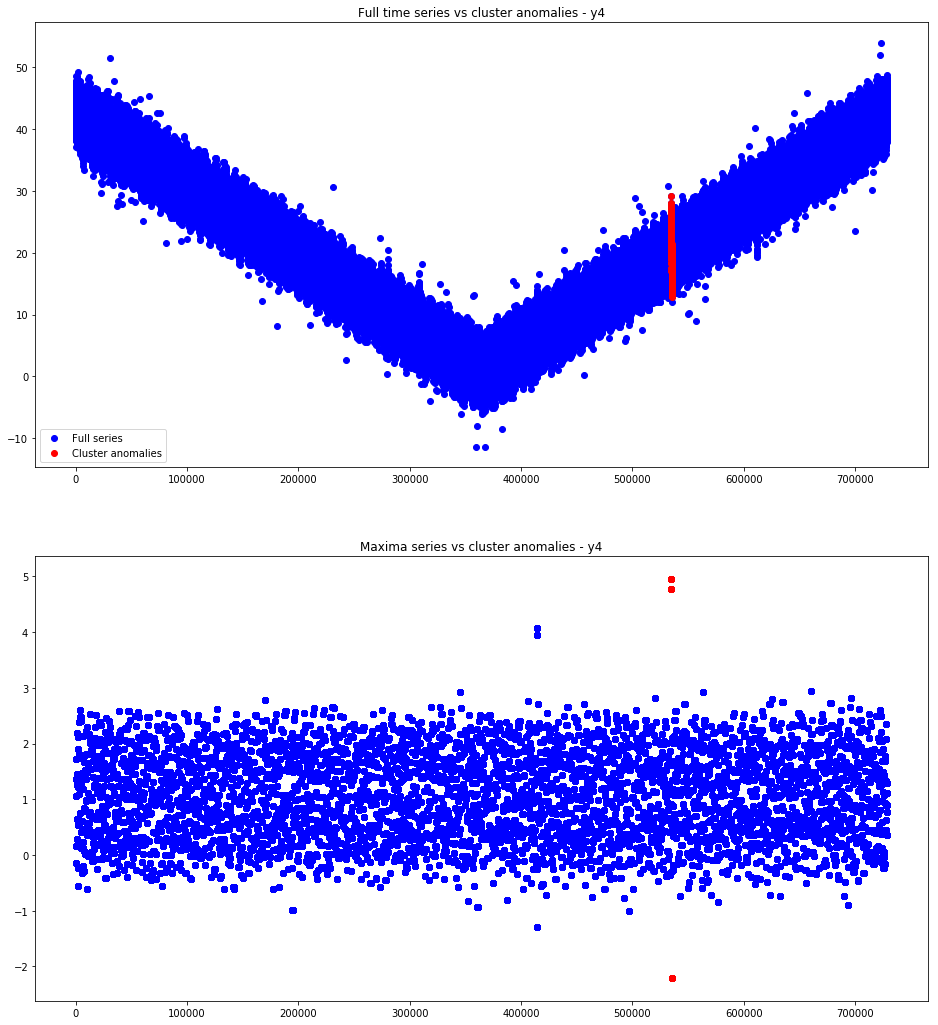

In [196]:
# #### Visualizing clusters ####
v = 'y4'
full_series = np.array(full_df[v]).reshape(-1, 1)
series = np.array(weekly_maxima_df[v]).reshape(-1, 1)
y_pred = np.array(cluster_flags_df[v]).reshape(-1, 1)
anomaly_idx = [i for i in range(n_data) if y_pred[i] == 1]
full_anomaly_values = [full_series[i] for i in anomaly_idx]
cluster_values = [series[i] for i in anomaly_idx]
# start = 410000
# end = 420000
# start = 530000
# end = 540000
start = 0
end = n_data
plot_idx = range(start, end)
plot_anomaly_idx = [x for x in anomaly_idx if start <= x <= end]
plot_full_anomaly_values = [full_series[i] for i in plot_anomaly_idx]
plot_cluster_values = [series[i] for i in plot_anomaly_idx]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
grid = plt.GridSpec(2, 1, wspace=0.1, hspace=0.2)
# Full time series vs cluster anomalies
ax1 = plt.subplot(grid[0, 0])
ax1.title.set_text('Full time series vs cluster anomalies - ' + v)
ax1.scatter(plot_idx, full_series[start:end], color='blue', label='Full series')
ax1.scatter(plot_anomaly_idx, plot_full_anomaly_values, color='red', label='Cluster anomalies')
ax1.legend(loc='best')
# Maxima series vs cluster anomalies
ax2 = plt.subplot(grid[1, 0])
ax2.title.set_text('Maxima series vs cluster anomalies - ' + v)
ax2.scatter(plot_idx, series[start:end], color='blue')
ax2.scatter(plot_anomaly_idx, plot_cluster_values, color='red')

plt.show()

In [197]:
# Beyond clusters, isolated anomalies also seem to exist here and there,
# without specific structure.
# We identify them as anomalies of the weekly residuals, as these are free
# of the cluster anomalies.

isolated_anomaly_std_threshold = 5.0
isolated_anomaly_probas = {}
isolated_anomaly_flags = {}
for v in variables:
    print("Fitting residuals for series {}".format(v))
    residual_series = weekly_residuals_df[v]
    x_train = np.array(residual_series).reshape(-1, 1)
    algo = PercentileDetection(isolated_anomaly_std_threshold)
    y_pred, anomaly_prob = algo.fit_predict(x_train)
    isolated_anomaly_probas[v] = [item[0] for item in anomaly_prob]
    isolated_anomaly_flags[v] = [1 if item[0] else 0 for item in y_pred]

isolated_anomaly_probas_df = pd.DataFrame(isolated_anomaly_probas)
isolated_anomaly_flags_df = pd.DataFrame(isolated_anomaly_flags)

# #### Exporting ####
if export_intermediate:
    print()
    print('Exporting isolated anomaly probabilities to tsv...')
    isolated_anomaly_probas_df.to_csv(isolated_probas_file, sep="\t", index=False)
    print('Exporting isolated anomaly flags to tsv...')
    isolated_anomaly_flags_df.to_csv(isolated_flags_file, sep="\t", index=False)

print("Done!")

Fitting residuals for series y1
Fitting residuals for series y2
Fitting residuals for series y3
Fitting residuals for series y4
Fitting residuals for series y5
Fitting residuals for series y6
Fitting residuals for series y7
Fitting residuals for series y8
Fitting residuals for series y9
Fitting residuals for series y10

Exporting isolated anomaly probabilities to tsv...
Exporting isolated anomaly flags to tsv...
Done!


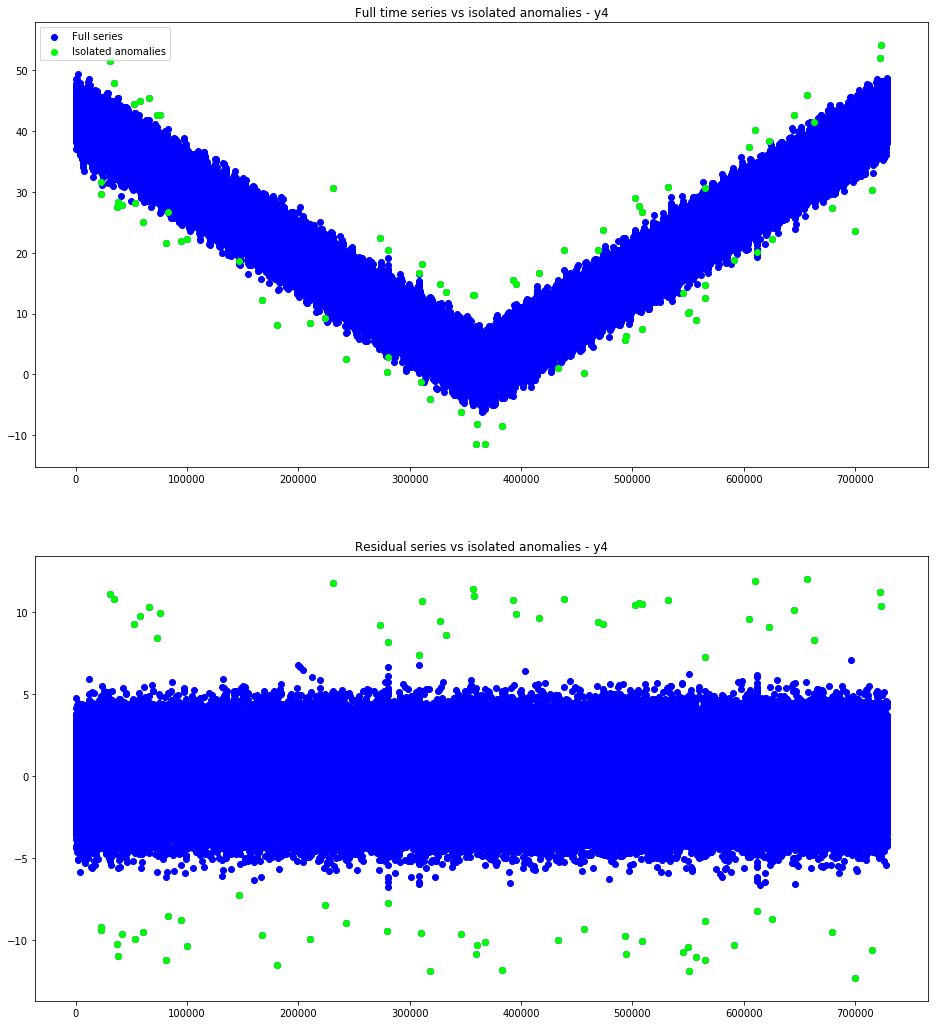

In [198]:
# #### Visualizing isolated anomalies ####
v = 'y4'
full_series = np.array(full_df[v]).reshape(-1, 1)
series = np.array(weekly_residuals_df[v]).reshape(-1, 1)
y_pred = np.array(isolated_anomaly_flags_df[v]).reshape(-1, 1)
anomaly_idx = [i for i in range(n_data) if y_pred[i] == 1]
full_anomaly_values = [full_series[i] for i in anomaly_idx]
isolated_anomaly_values = [series[i] for i in anomaly_idx]
start = 0
end = n_data
plot_idx = range(start, end)
plot_anomaly_idx = [x for x in anomaly_idx if start <= x <= end]
plot_full_anomaly_values = [full_series[i] for i in plot_anomaly_idx]
plot_isolated_anomaly_values = [series[i] for i in plot_anomaly_idx]

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(16, 18))
grid = plt.GridSpec(2, 1, wspace=0.1, hspace=0.2)
# Full time series vs isolated anomalies
ax1 = plt.subplot(grid[0, 0])
ax1.title.set_text('Full time series vs isolated anomalies - ' + v)
ax1.scatter(plot_idx, full_series[start:end], color='blue', label='Full series')
ax1.scatter(plot_anomaly_idx, plot_full_anomaly_values, color='lime', label='Isolated anomalies')
ax1.legend(loc='best')
# Residual series vs isolated anomalies
ax2 = plt.subplot(grid[1, 0])
ax2.title.set_text('Residual series vs isolated anomalies - ' + v)
ax2.scatter(plot_idx, series[start:end], color='blue')
ax2.scatter(plot_anomaly_idx, plot_isolated_anomaly_values, color='lime')

plt.show()

In [199]:
# Combine cluster and isolated anomaly probabilities into an overall anomaly
# probability defined as the max of both.

final_probas = {}
final_flags = {}
for v in variables:
    print("Combining probabilities for series {}".format(v))
    final_probas[v] = np.maximum(cluster_probas_df[v], isolated_anomaly_probas_df[v])
    final_flags[v] = [1 if p >= 0.90 else 0 for p in final_probas[v]]

final_probas_df = pd.DataFrame(final_probas)
final_flags_df = pd.DataFrame(final_flags)
    
# #### Exporting ####
if export_intermediate:
    print()
    print('Exporting final probabilities to tsv...')
    final_probas_df.to_csv(final_probas_file, sep="\t", index=False)
    print('Exporting final flags to tsv...')
    final_flags_df.to_csv(final_flags_file, sep="\t", index=False)
    
print("Done!")

Combining probabilities for series y1
Combining probabilities for series y2
Combining probabilities for series y3
Combining probabilities for series y4
Combining probabilities for series y5
Combining probabilities for series y6
Combining probabilities for series y7
Combining probabilities for series y8
Combining probabilities for series y9
Combining probabilities for series y10

Exporting final probabilities to tsv...
Exporting final flags to tsv...
Done!


In [183]:
# Small utility to plot final charts with overall anomalies
def plot_final(v, plot_start, plot_end, full_df, final_proba_df, final_flag_df):
    full_series = full_df[v]
    flag_series = final_flag_df[v]
    proba_series = final_proba_df[v]
    plot_idx = range(plot_start, plot_end)
    n_data = len(full_series)
    # Find which elements are anomalies and corresponding values
    anomaly_idx = [i for i in range(n_data) if flag_series[i] == 1]
    plot_anomaly_idx = [x for x in anomaly_idx if plot_start <= x < plot_end]
    plot_full_anomaly_values = [full_series[i] for i in plot_anomaly_idx]

    plt.figure(figsize=(11, 4))
    plt.title(v)
    plt.scatter(plot_idx, full_series[plot_idx], color='blue', label='Full series')
    plt.scatter(plot_anomaly_idx, plot_full_anomaly_values, color='red', label='Anomalies')
    plt.legend(loc='best')
    plt.show()
    

# Small utility to plot final charts distinguishing between cluster and isolated anomalies
def plot_final_split(v, plot_start, plot_end, full_df, cluster_proba_df, cluster_flag_df,
                     isolated_proba_df, isolated_flag_df):
    full_series = full_df[v]
    cluster_flag_series = cluster_flag_df[v]
    cluster_proba_series = cluster_proba_df[v]
    isolated_flag_series = isolated_flag_df[v]
    isolated_proba_series = isolated_proba_df[v]
    plot_idx = range(plot_start, plot_end)
    n_data = len(full_series)
    # Find cluster anomalies
    cluster_anomaly_idx = [i for i in range(n_data) if cluster_flag_series[i] == 1]
    plot_cluster_anomaly_idx = [x for x in cluster_anomaly_idx if plot_start <= x < plot_end]
    plot_cluster_anomaly_values = [full_series[i] for i in plot_cluster_anomaly_idx]
    # Find isolated anomalies
    isolated_anomaly_idx = [i for i in range(n_data) if isolated_flag_series[i] == 1]
    plot_isolated_anomaly_idx = [x for x in isolated_anomaly_idx if plot_start <= x < plot_end]
    plot_isolated_anomaly_values = [full_series[i] for i in plot_isolated_anomaly_idx]

    plt.figure(figsize=(11, 4))
    plt.title(v)
    plt.scatter(plot_idx, full_series[plot_idx], color='blue', alpha=0.5,
                label='Series')
    plt.scatter(plot_cluster_anomaly_idx, plot_cluster_anomaly_values, color='red',
                label='Clusters')
    plt.scatter(plot_isolated_anomaly_idx, plot_isolated_anomaly_values, color='lime',
                label='Isolated Anomalies')
    plt.legend(loc='best')
    plt.show()

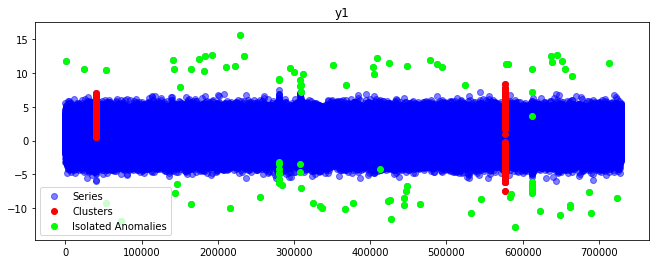

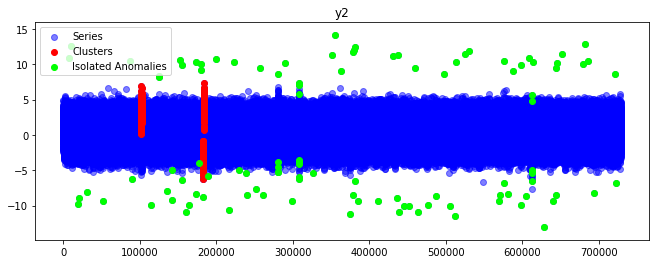

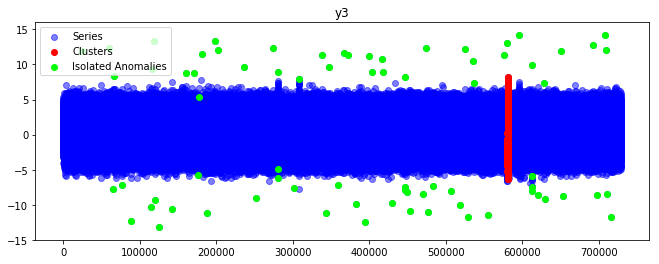

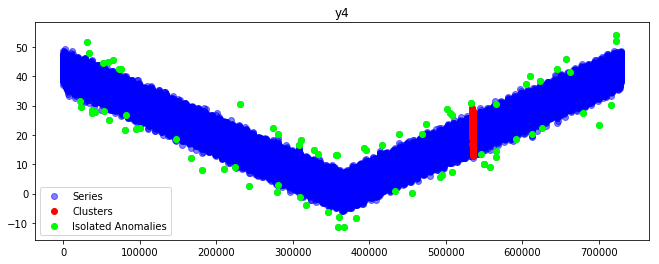

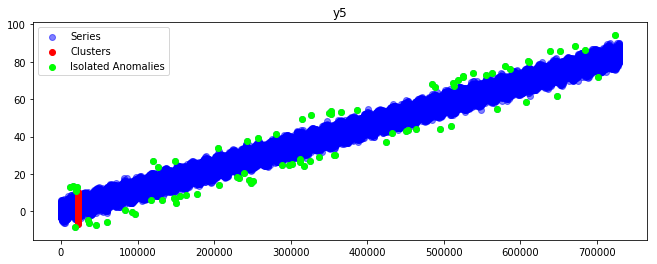

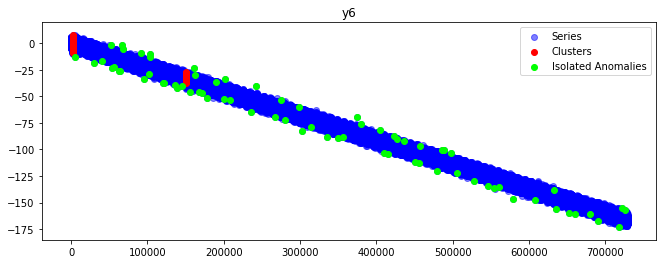

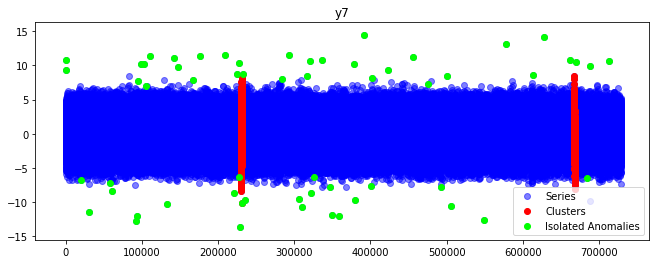

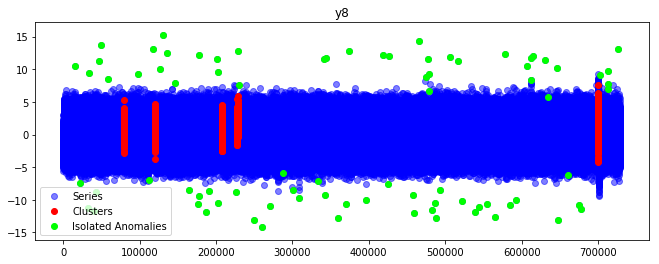

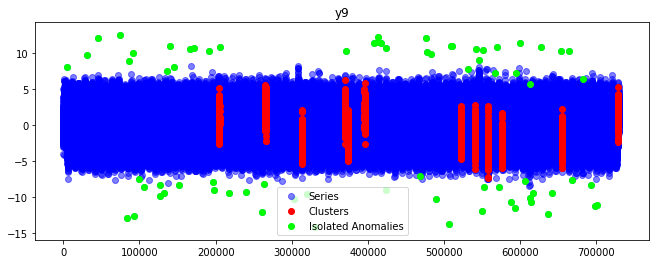

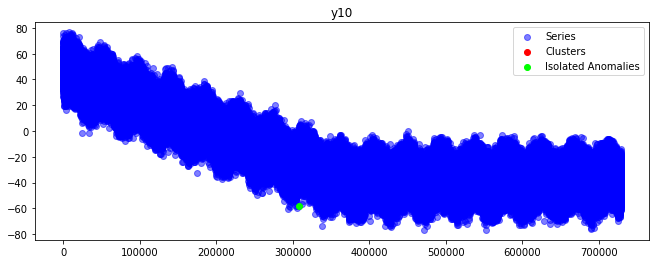

In [184]:
# #### Visualizing anomalies ####
start = 0
end = n_data
# start = 609000
# end = 612000
display_split = True
# for v in ['y10']:
for v in variables:
    if display_split:
        plot_final_split(v, start, end, full_df, cluster_probas_df, cluster_flags_df,
                         isolated_anomaly_probas_df, isolated_anomaly_flags_df)
    else:
        plot_final(v, start, end, full_df, final_probas_df, final_flags_df)        